In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [28]:
data_train = pd.read_csv('train_data.csv', delimiter=';')
data_test = pd.read_csv('test_data.csv', delimiter=';')

In [29]:
# Convertir la variable categórica en numérica
data_train.head(5)

,id_colaborador,id_ultimo_jefe,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,fecha_nacimiento,salario,performance_score,psi_score,fecha_incorporacion,estado_civil,abandono_6meses
0,100247,102074.0,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,25/11/1999,140011,99.0,75,25/01/2018,Soltero,0
1,103355,102115.0,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,16/10/1996,182774,99.0,81,24/07/2021,Soltero,1
2,100669,102060.0,1,Híbrida,4.950,3,Mujer,Referidos,11,29/01/1971,682106,96.0,74,13/07/2016,Viudo,0
3,103760,102062.0,1,Híbrida,13.030,2,Hombre,Linkedin,2,28/04/1992,270232,96.0,82,21/07/2014,Soltero,1
4,100965,102062.0,1,Híbrida,13.045,2,Hombre,Linkedin,2,3/05/1992,266804,95.0,82,22/07/2014,Soltero,0


In [30]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_colaborador        2152 non-null   int64  
 1   id_ultimo_jefe        2061 non-null   float64
 2   seniority             2152 non-null   int64  
 3   modalidad_trabajo     2152 non-null   object 
 4   distancia_oficina     2152 non-null   float64
 5   dias_baja_salud       2152 non-null   int64  
 6   genero                2152 non-null   object 
 7   canal_reclutamiento   2152 non-null   object 
 8   permanencia_promedio  2152 non-null   int64  
 9   fecha_nacimiento      2152 non-null   object 
 10  salario               2152 non-null   int64  
 11  performance_score     2084 non-null   float64
 12  psi_score             2152 non-null   int64  
 13  fecha_incorporacion   2152 non-null   object 
 14  estado_civil          2152 non-null   object 
 15  abandono_6meses      

In [31]:
## Imputación de datos faltantes

imputer = SimpleImputer(strategy='mean')

## De acuerdo a los datos solo se aplicará la imputación a performance_score. id_ultimo_jefe será eliminada pues no aporta información relevante

data_train['performance_score'] = imputer.fit_transform(data_train[['performance_score']])

data_train = data_train.drop(columns=['id_ultimo_jefe'])


In [32]:
columnas_categoricas = [col for col in data_train.select_dtypes(include=['object']).columns if col not in ['fecha_nacimiento', 'fecha_incorporacion']]
columnas_categoricas = [col for col in data_test.select_dtypes(include=['object']).columns if col not in ['fecha_nacimiento', 'fecha_incorporacion']]
mapeos = {}


In [33]:
for columna in columnas_categoricas:
    le = LabelEncoder()
    data_train[columna] = le.fit_transform(data_train[columna].fillna('desconocida'))
    data_test[columna] = le.transform(data_test[columna].fillna('desconocida'))
    # Almacenar el mapeo de categorías a números para cada columna
    mapeos[columna] = dict(zip(le.classes_, le.transform(le.classes_)))

In [34]:
# Imprimir los mapeos
for columna, mapeo in mapeos.items():
    print(f"Mapeo para '{columna}': {mapeo}")


Mapeo para 'modalidad_trabajo': {'Híbrida': 0, 'Presencial': 1}
Mapeo para 'genero': {'Hombre': 0, 'Mujer': 1}
Mapeo para 'canal_reclutamiento': {'Ferias & Networking': 0, 'Headhunter': 1, 'Linkedin': 2, 'Portal Web': 3, 'Referidos': 4}
Mapeo para 'estado_civil': {'Casado': 0, 'Divorciado': 1, 'Soltero': 2, 'Viudo': 3}


In [35]:
data_train.head(5)

,id_colaborador,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,fecha_nacimiento,salario,performance_score,psi_score,fecha_incorporacion,estado_civil,abandono_6meses
0,100247,1,0,1.760,1,1,0,1,25/11/1999,140011,99.0,75,25/01/2018,2,0
1,103355,1,0,0.760,2,0,0,2,16/10/1996,182774,99.0,81,24/07/2021,2,1
2,100669,1,0,4.950,3,1,4,11,29/01/1971,682106,96.0,74,13/07/2016,3,0
3,103760,1,0,13.030,2,0,2,2,28/04/1992,270232,96.0,82,21/07/2014,2,1
4,100965,1,0,13.045,2,0,2,2,3/05/1992,266804,95.0,82,22/07/2014,2,0


In [36]:
X = data_train.drop(['abandono_6meses', 'fecha_nacimiento', 'fecha_incorporacion', 'id_colaborador', ], axis=1)
y = data_train['abandono_6meses']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputación para manejar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Normalización de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Entrenar un modelo de Random Forest
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train_scaled, y_train)

# Evaluar el modelo
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy del modelo: {accuracy}')

# Obtener la importancia de las características
importancias = rf.feature_importances_
caracteristicas = X.columns
df_importancias = pd.DataFrame({'Caracteristica': caracteristicas, 'Importancia': importancias}).sort_values('Importancia', ascending=False)

print(df_importancias)

Accuracy del modelo: 0.6844547563805105
          Caracteristica  Importancia
8      performance_score     0.214279
7                salario     0.169777
2      distancia_oficina     0.162725
9              psi_score     0.118212
6   permanencia_promedio     0.096727
3        dias_baja_salud     0.087581
5    canal_reclutamiento     0.051505
10          estado_civil     0.042435
4                 genero     0.023897
1      modalidad_trabajo     0.021255
0              seniority     0.011607


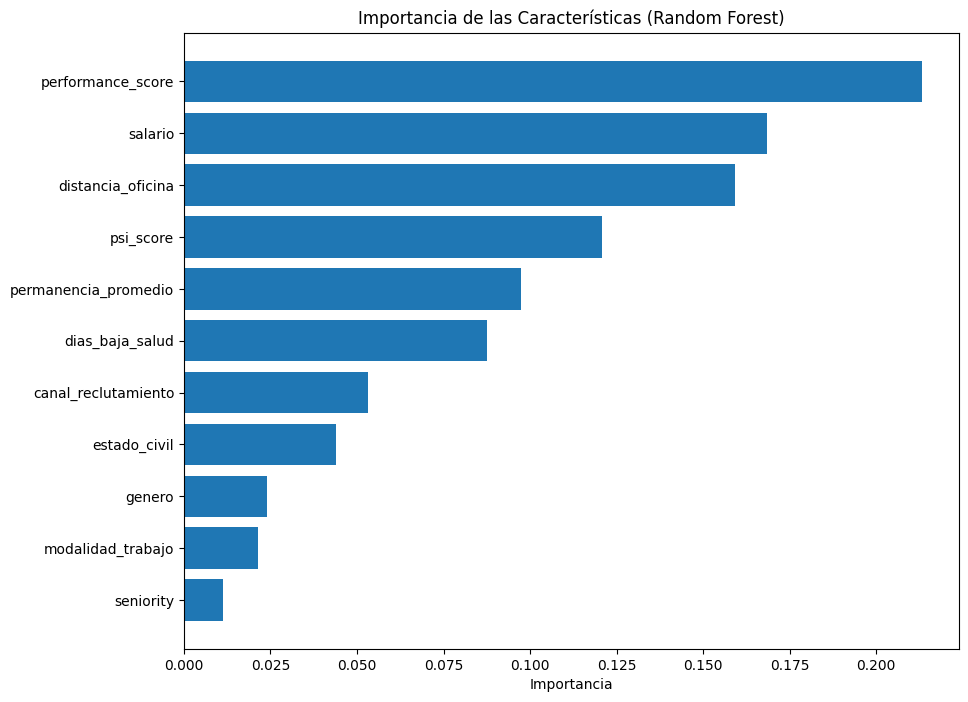

In [37]:
# Inicializar el modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
rf.fit(X_train, y_train)

# Obtener la importancia de las características
importancias = rf.feature_importances_
caracteristicas = X_train.columns

# Crear un DataFrame para visualizar la importancia de las características
df_importancias = pd.DataFrame({'Caracteristica': caracteristicas, 'Importancia': importancias})
df_importancias = df_importancias.sort_values('Importancia', ascending=False)

# Visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plt.barh(df_importancias['Caracteristica'], df_importancias['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Características (Random Forest)')
plt.gca().invert_yaxis()  # Invertir el eje y para tener la característica más importante en la parte superior
plt.show()

# Considerar solo las características más importantes según algún criterio definido por ti
# Por ejemplo, podrías elegir mantener solo las características que contribuyen con el 95% de la importancia total
importancia_total = df_importancias['Importancia'].sum()
importancia_acumulada = 0
caracteristicas_seleccionadas = []

for i, row in df_importancias.iterrows():
    importancia_acumulada += row['Importancia']
    caracteristicas_seleccionadas.append(row['Caracteristica'])
    if importancia_acumulada >= 0.95 * importancia_total:
        break

# X_train_reducido y X_test_reducido contienen solo las características seleccionadas
X_train_reducido = X_train[caracteristicas_seleccionadas]
X_test_reducido = X_test[caracteristicas_seleccionadas]

Caracteristica  Importancia
0         id_colaborador     0.169263
10     performance_score     0.168497
9                salario     0.112613
1         id_ultimo_jefe     0.106890
4      distancia_oficina     0.103673
11             psi_score     0.081530
5        dias_baja_salud     0.069965
8   permanencia_promedio     0.068987
7    canal_reclutamiento     0.039860
12          estado_civil     0.030111
6                 genero     0.020053
3      modalidad_trabajo     0.015582
2              seniority     0.012975

Se eliminan las variables que aportan menos de 0.05 de importancia en el modelo.

In [38]:
## Se eliminan las variables que aportan menos de 0.05 de importancia en el modelo.

columnas_a_eliminar = ['canal_reclutamiento', 'estado_civil', 'genero', 'modalidad_trabajo', 'seniority']

# Eliminar las columnas del DataFrame
X_reducido = X.drop(columnas_a_eliminar, axis=1)

# Si ya tienes dividido tu conjunto en X_train y X_test, debes aplicar la misma eliminación
X_train_reducido = X_train.drop(columnas_a_eliminar, axis=1)
X_test_reducido = X_test.drop(columnas_a_eliminar, axis=1)

In [42]:
# Función para calcular RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Crear scorers
scoring = {'RMSE': make_scorer(rmse, greater_is_better=False), 
            'MAE': 'neg_mean_absolute_error', 
            'R2': 'r2'
            }

# Lista de modelos a evaluar
modelos = [
    {'nombre': 'Regresión Lineal', 'modelo': LinearRegression(), 'parametros': {}},
    {'nombre': 'Árbol de Decisión', 'modelo': DecisionTreeRegressor(), 'parametros': {'max_depth': [2, 5, 10, 20, 40]}},
    {'nombre': 'Bosque Aleatorio', 'modelo': RandomForestRegressor(), 'parametros': {'n_estimators': [10, 50, 100, 1000], 'max_depth': [2, 5, 10, 20]}}
]

resultados = []

for modelo in modelos:
    grid = GridSearchCV(modelo['modelo'], modelo['parametros'], scoring=scoring, refit='RMSE', return_train_score=True, cv=10)
    grid.fit(X_train_reducido, y_train)
    mejores_resultados = {
        'Modelo': modelo['nombre'],
        'Mejor RMSE': -grid.best_score_,  # Negamos porque los scores negativos indican error
        'Mejor configuración': grid.best_params_
    }
    for scorer in scoring:
        mejores_resultados[f'Mejor {scorer}'] = -grid.cv_results_[f'mean_test_{scorer}'][grid.best_index_] if scorer != 'R2' else grid.cv_results_[f'mean_test_{scorer}'][grid.best_index_]
    resultados.append(mejores_resultados)

# Convertir los resultados a un DataFrame para una mejor visualización
df_resultados = pd.DataFrame(resultados)

In [43]:
df_resultados

,Modelo,Mejor RMSE,Mejor configuración,Mejor MAE,Mejor R2
0,Regresión Lineal,0.472164,{},0.444901,0.097240
1,Árbol de Decisión,0.477091,{'max_depth': 2},0.447238,0.078011
2,Bosque Aleatorio,0.467679,"{'max_depth': 5, 'n_estimators': 100}",0.432988,0.114117


In [45]:

test_data = data_test.drop(columns=['id_colaborador', 'fecha_nacimiento', 'fecha_incorporacion', 'id_ultimo_jefe', 'canal_reclutamiento', 'estado_civil', 'genero', 'modalidad_trabajo', 'seniority'])
mejor_modelo = grid.best_estimator_
predicciones = mejor_modelo.predict(test_data)

In [48]:
mejor_modelo = grid.best_estimator_
mejores_parametros = grid.best_params_

print(mejores_parametros)

{'max_depth': 5, 'n_estimators': 100}


In [46]:
print(predicciones)

[0.57316113 0.23222655 0.24503792 ... 0.24599019 0.28230463 0.29847125]


In [50]:
umbral_predicciones = (predicciones >= 0.5).astype(int)

# Crear un DataFrame con las predicciones

df_predicciones = pd.DataFrame({'ID': data_test['id_colaborador'], 'abandono_6meses': umbral_predicciones})

# Guardar las predicciones en un archivo CSV
df_predicciones.to_csv('predicciones.csv', index=False)

In [49]:
sample = pd.read_csv('sample_submission.csv')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               10 non-null     int64
 1   abandono_6meses  10 non-null     int64
dtypes: int64(2)
memory usage: 292.0 bytes
